#TRANSFER LEARNING

Model 1: VGG16

In [ ]:
#IMPORTING DATASET FROM KAGGLE
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

pneumonia-xray-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"

zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

#####Importing libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import RMSprop
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img


In [ ]:
IMAGE_SIZE = [244,244]

train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'

In [ ]:
vgg16 = VGG16(input_shape=IMAGE_SIZE +[3], weights = 'imagenet', include_top = False)

In [ ]:
for layer in vgg16.layers:
  layer.trainable = False  #Freezing the layers

In [ ]:
import glob
folders = glob.glob('/content/dataset/cnn/pneumonia_revamped/train')

In [ ]:
x = Flatten()(vgg16.output) #Flattening

In [ ]:
len(folders)

1

In [ ]:
prediction = Dense(1, activation = 'sigmoid')(x) #Output layer

In [ ]:
model = Model(inputs=vgg16.input, outputs = prediction)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 61, 61, 128)       0     

In [ ]:
model.compile(
    loss = 'binary_crossentropy',   #Compiling the model
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

image_gen = ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                              
                               )  

test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = image_gen.flow_from_directory('/content/dataset/cnn/pneumonia_revamped/train',
                                             target_size = (244,244),
                                             batch_size = 32,
                                             class_mode = 'binary')

Found 4192 images belonging to 2 classes.


In [ ]:
test_set = image_gen.flow_from_directory('/content/dataset/cnn/pneumonia_revamped/test',
                                             target_size = (244,244),
                                             batch_size = 32,
                                             class_mode = 'binary')

Found 624 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [early]

In [ ]:
vnet = model.fit(
    training_set,
    validation_data = test_set,
    epochs = 20,
    steps_per_epoch = len(training_set),
    validation_steps = len(test_set),
    callbacks = callbacks_list
)

Epoch 1/20
131/131 [==============================] - 150s 1s/step - loss: 0.1626 - accuracy: 0.9342 - val_loss: 0.3627 - val_accuracy: 0.8766
Epoch 2/20
131/131 [==============================] - 129s 981ms/step - loss: 0.1132 - accuracy: 0.9571 - val_loss: 0.3663 - val_accuracy: 0.8782
Epoch 3/20
131/131 [==============================] - 128s 974ms/step - loss: 0.0892 - accuracy: 0.9678 - val_loss: 0.4812 - val_accuracy: 0.8269
Epoch 4/20
131/131 [==============================] - 127s 968ms/step - loss: 0.0866 - accuracy: 0.9666 - val_loss: 0.2231 - val_accuracy: 0.9199
Epoch 5/20
131/131 [==============================] - 127s 972ms/step - loss: 0.0922 - accuracy: 0.9654 - val_loss: 0.4553 - val_accuracy: 0.8558
Epoch 6/20
131/131 [==============================] - 127s 966ms/step - loss: 0.0720 - accuracy: 0.9754 - val_loss: 0.4454 - val_accuracy: 0.8702
Epoch 7/20
131/131 [==============================] - 126s 964ms/step - loss: 0.0685 - accuracy: 0.9738 - val_loss: 0.5754 - va

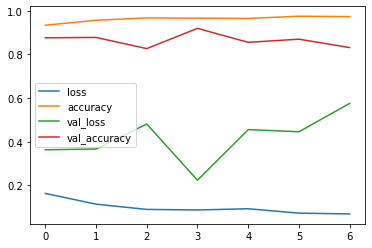

In [ ]:
pd.DataFrame(model.history.history).plot()

In [ ]:
test_accu = model.evaluate(test_set)
print('The testing accuracy is :',test_accu[1]*100, '%')

20/20 [==============================] - 16s 767ms/step - loss: 0.5742 - accuracy: 0.8285
The testing accuracy is : 82.85256624221802 %


In [ ]:
preds = model.predict(test_set,verbose=1)

20/20 [==============================] - 16s 796ms/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

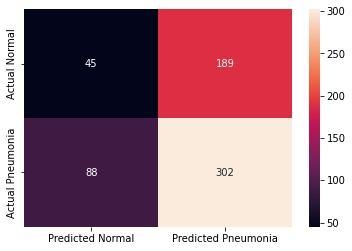

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm1 = pd.DataFrame(data=confusion_matrix(test_set.classes, predictions, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm1,annot=True,fmt="d")

In [ ]:
 print(classification_report(y_true=test_set.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

      NORMAL       0.34      0.19      0.25       234
   PNEUMONIA       0.62      0.77      0.69       390

    accuracy                           0.56       624
   macro avg       0.48      0.48      0.47       624
weighted avg       0.51      0.56      0.52       624



In [ ]:
test_set.reset()
x=np.concatenate([test_set.next()[0] for i in range(test_set.__len__())])
y=np.concatenate([test_set.next()[1] for i in range(test_set.__len__())])
print(x.shape)
print(y.shape)

(624, 244, 244, 3)
(624,)


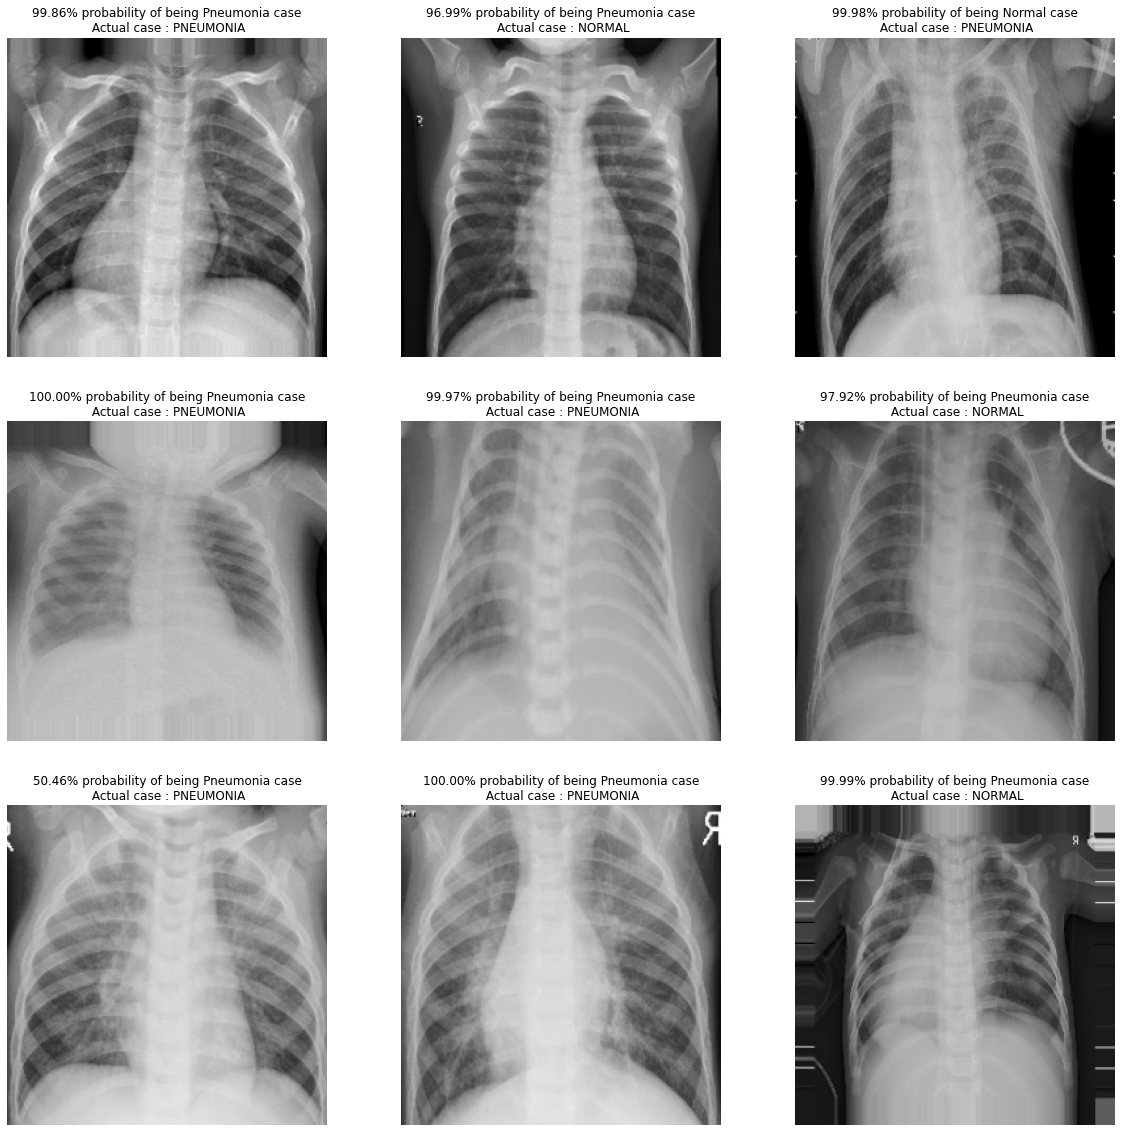

In [ ]:
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
      
      

  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

Model 2: VGG19

In [ ]:
from keras.applications.vgg19 import VGG19

In [ ]:
vgg19 = VGG19(input_shape=IMAGE_SIZE +[3], weights = 'imagenet', include_top = False)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg19.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg19.output) #Flattening

In [ ]:
prediction = Dense(1, activation = 'sigmoid')(x) #Output layer

In [ ]:
model1 = Model(inputs=vgg19.input, outputs = prediction)

In [ ]:
model1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 61, 61, 128)       0   

In [ ]:
model1.compile(
    loss = 'binary_crossentropy',   #Compiling the model
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [early]

In [ ]:
vnet19 = model1.fit(
    training_set,
    validation_data = test_set,
    epochs = 20,
    steps_per_epoch = len(training_set),
    validation_steps = len(test_set),
    callbacks = callbacks_list
)

Epoch 1/20
131/131 [==============================] - 129s 979ms/step - loss: 0.2086 - accuracy: 0.9096 - val_loss: 0.5214 - val_accuracy: 0.7949
Epoch 2/20
131/131 [==============================] - 129s 981ms/step - loss: 0.1296 - accuracy: 0.9490 - val_loss: 0.4143 - val_accuracy: 0.8510
Epoch 3/20
131/131 [==============================] - 129s 985ms/step - loss: 0.1143 - accuracy: 0.9532 - val_loss: 0.5980 - val_accuracy: 0.8093
Epoch 4/20
131/131 [==============================] - 130s 993ms/step - loss: 0.1086 - accuracy: 0.9573 - val_loss: 0.6013 - val_accuracy: 0.8077
Epoch 5/20
131/131 [==============================] - 128s 974ms/step - loss: 0.1053 - accuracy: 0.9611 - val_loss: 0.3154 - val_accuracy: 0.8894
Epoch 6/20
131/131 [==============================] - 131s 998ms/step - loss: 0.1113 - accuracy: 0.9554 - val_loss: 0.4876 - val_accuracy: 0.8494
Epoch 7/20
131/131 [==============================] - 130s 996ms/step - loss: 0.0842 - accuracy: 0.9656 - val_loss: 0.4335 -

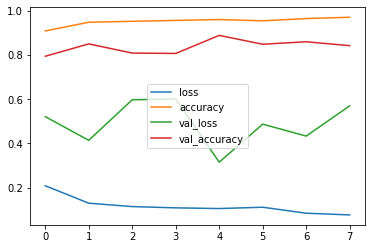

In [ ]:
pd.DataFrame(model1.history.history).plot()

In [ ]:
test_accu = model1.evaluate(test_set)
print('The testing accuracy is :',test_accu[1]*100, '%')

20/20 [==============================] - 17s 813ms/step - loss: 0.5336 - accuracy: 0.8446
The testing accuracy is : 84.45512652397156 %


In [ ]:
preds1 = model1.predict(test_set,verbose=1)

20/20 [==============================] - 16s 779ms/step


In [ ]:
predictions1 = preds1.copy()
predictions1[predictions1 <= 0.5] = 0
predictions1[predictions1 > 0.5] = 1

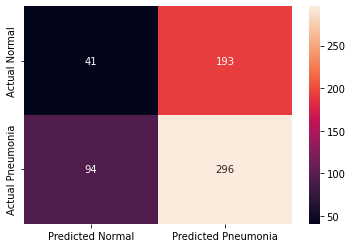

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm2 = pd.DataFrame(data=confusion_matrix(test_set.classes, predictions1, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm2,annot=True,fmt="d")

In [ ]:
print(classification_report(y_true=test_set.classes, y_pred=predictions1,
                            target_names =['NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

      NORMAL       0.30      0.18      0.22       234
   PNEUMONIA       0.61      0.76      0.67       390

    accuracy                           0.54       624
   macro avg       0.45      0.47      0.45       624
weighted avg       0.49      0.54      0.50       624

